In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
tqdm.pandas()

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/atis_train.csv')
train.columns = ['id','intent', 'text','slots']
print(train.shape)
train.head()

(4978, 4)


,id,intent,text,slots
0,0,flight,i want to fly from boston at 838 am and arrive...,O O O O O B-fromloc.city_name O B-depart_time....
1,1,flight,what flights are available from pittsburgh to ...,O O O O O B-fromloc.city_name O B-toloc.city_n...
2,2,flight_time,what is the arrival time in san francisco for ...,O O O B-flight_time I-flight_time O B-fromloc....
3,3,airfare,cheapest airfare from tacoma to orlando,B-cost_relative O O B-fromloc.city_name O B-to...
4,4,airfare,round trip fares from pittsburgh to philadelph...,B-round_trip I-round_trip O O B-fromloc.city_n...


In [7]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/atis_test.csv')
test.columns = ['id','intent', 'text','slots']

print(test.shape)
test.head()

(893, 4)


,id,intent,text,slots
0,0,flight,i would like to find a flight from charlotte t...,O O O O O O O O B-fromloc.city_name O B-toloc....
1,1,airfare,on april first i need a ticket from tacoma to ...,O B-depart_date.month_name B-depart_date.day_n...
2,2,flight,on april first i need a flight going from phoe...,O B-depart_date.month_name B-depart_date.day_n...
3,3,flight,i would like a flight traveling one way from p...,O O O O O O B-round_trip I-round_trip O B-from...
4,4,flight,i would like a flight from orlando to salt lak...,O O O O O O B-fromloc.city_name O B-toloc.city...


In [8]:
test.intent.value_counts(), test.intent.value_counts(normalize=True)

(flight               632
 airfare               48
 airline               38
 ground_service        36
 abbreviation          33
 capacity              21
 airport               18
 flight+airfare        12
 distance              10
 aircraft               9
 flight_no              8
 ground_fare            7
 city                   6
 meal                   6
 quantity               3
 day_name               2
 flight_time            1
 airfare+flight         1
 flight+airline         1
 flight_no+airline      1
 Name: intent, dtype: int64,
 flight               0.707727
 airfare              0.053751
 airline              0.042553
 ground_service       0.040314
 abbreviation         0.036954
 capacity             0.023516
 airport              0.020157
 flight+airfare       0.013438
 distance             0.011198
 aircraft             0.010078
 flight_no            0.008959
 ground_fare          0.007839
 city                 0.006719
 meal                 0.006719
 quantity        

In [9]:
train_data = train.text.values
train_labels = train.intent.values
test_data = test.text.values
test_labels = test.intent.values

len(train_data), len(train_labels), len(test_data), len(test_labels)

(4978, 4978, 893, 893)

In [10]:
print(train_data[123])
print(train_labels[123])

what are the nonstop flights on america west or southwest air from kansas city to burbank on saturday may twenty two
flight


In [11]:
y_train = pd.get_dummies(train_labels)
print(y_train.shape)
y_train.head()

(4978, 22)


,abbreviation,aircraft,aircraft+flight+flight_no,airfare,airfare+flight_time,airline,airline+flight_no,airport,capacity,cheapest,...,flight,flight+airfare,flight_no,flight_time,ground_fare,ground_service,ground_service+ground_fare,meal,quantity,restriction
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_test = pd.get_dummies(test_labels)
print(y_test.shape)
y_test.head()

(893, 20)


,abbreviation,aircraft,airfare,airfare+flight,airline,airport,capacity,city,day_name,distance,flight,flight+airfare,flight+airline,flight_no,flight_no+airline,flight_time,ground_fare,ground_service,meal,quantity
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [13]:
%%time
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

CPU times: user 15.2 s, sys: 3.24 s, total: 18.4 s
Wall time: 37.1 s


In [14]:
def build_model(embed):

    model = Sequential([
        Input(shape=[], dtype=tf.string),
        embed,
        Dense(8, activation='softmax')
    ])
    model.compile(Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_model(embed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  {'outputs': (None, 512)   147354880 
                             }                                   
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 147358984 (562.13 MB)
Trainable params: 147358984 (562.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=8)


In [17]:
model.add(Dense(22, activation='softmax'))  # Adjust the number of units based on your use case


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
print("Input data shape:", train_data.shape)
print("Target labels shape:", y_train.shape)


Input data shape: (4978,)
Target labels shape: (4978, 22)


In [20]:
checkpoint = ModelCheckpoint('modelATIS.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_data, y_train,
    validation_split=0.20,
    epochs = 10,
    callbacks=[checkpoint],
    batch_size=32
)

Epoch 1/10


125/125 [==============================] - ETA: 0s - loss: 2.6497 - accuracy: 0.7431

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 666s 3s/step - loss: 2.6497 - accuracy: 0.7431 - val_loss: 2.4076 - val_accuracy: 0.8032
Epoch 2/10
125/125 [==============================] - 351s 3s/step - loss: nan - accuracy: 0.2845 - val_loss: nan - val_accuracy: 0.0311
Epoch 3/10
125/125 [==============================] - 352s 3s/step - loss: nan - accuracy: 0.0291 - val_loss: nan - val_accuracy: 0.0311
Epoch 4/10
125/125 [==============================] - 348s 3s/step - loss: nan - accuracy: 0.0291 - val_loss: nan - val_accuracy: 0.0311
Epoch 5/10
125/125 [==============================] - 352s 3s/step - loss: nan - accuracy: 0.0291 - val_loss: nan - val_accuracy: 0.0311
Epoch 6/10
125/125 [==============================] - 354s 3s/step - loss: nan - accuracy: 0.0291 - val_loss: nan - val_accuracy: 0.0311
Epoch 7/10
125/125 [==============================] - 352s 3s/step - loss: nan - accuracy: 0.0291 - val_loss: nan - val_accuracy: 0.0311
Epoch 8/10
125/125 [==========================

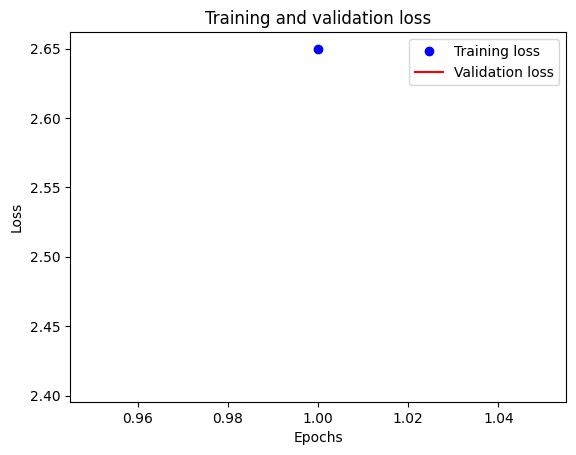

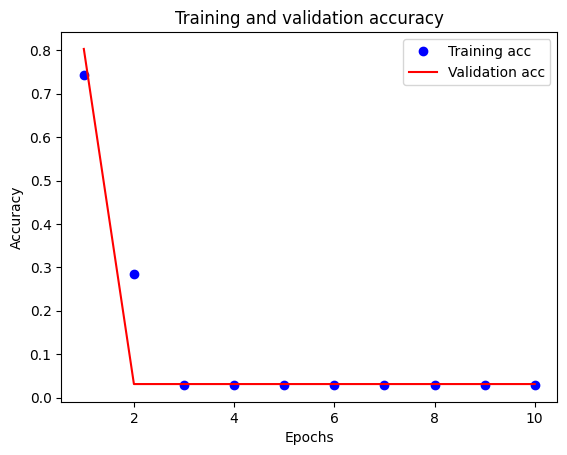

In [21]:
# VALIDATION LOSS curves

plt.clf()
history_dict = train_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
rawPreds = model.predict(test_data)
rawPreds.shape

28/28 [==============================] - 22s 363ms/step


(893, 22)

In [23]:
Preds = []

for j in range(rawPreds.shape[0]):
    pos = rawPreds[j].argmax()
    Preds.append(y_test.columns[pos])

len(Preds)

893

In [24]:
print(classification_report(Preds, test_labels))

                   precision    recall  f1-score   support

     abbreviation       1.00      0.04      0.07       893
         aircraft       0.00      0.00      0.00         0
          airfare       0.00      0.00      0.00         0
   airfare+flight       0.00      0.00      0.00         0
          airline       0.00      0.00      0.00         0
          airport       0.00      0.00      0.00         0
         capacity       0.00      0.00      0.00         0
             city       0.00      0.00      0.00         0
         day_name       0.00      0.00      0.00         0
         distance       0.00      0.00      0.00         0
           flight       0.00      0.00      0.00         0
   flight+airfare       0.00      0.00      0.00         0
   flight+airline       0.00      0.00      0.00         0
        flight_no       0.00      0.00      0.00         0
flight_no+airline       0.00      0.00      0.00         0
      flight_time       0.00      0.00      0.00       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Input text
text = "I want to book a flight to Dhaka tomorrow and return to Chittagong this Friday evening."

# Process the text with spaCy
doc = nlp(text)

# Extract date and location entities
date_entities = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
location_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]

# Print the extracted information
print("Dates:", date_entities)
print("Locations:", location_entities)

Dates: ['tomorrow', 'Friday']
Locations: []


In [26]:
import pandas as pd
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load your dataset
# Replace 'your_dataset.csv' with the actual path to your dataset CSV file
df = pd.read_csv('/content/drive/MyDrive/Dataset/atis_train.csv')

# Function to extract date and location entities from a given text
def extract_entities(text):
    doc = nlp(text)
    date_entities = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
    location_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return {'Dates': date_entities, 'Locations': location_entities}

# Apply the function to the 'text' column in the DataFrame
df['Entities'] = df['text'].apply(extract_entities)

# Display the results
print(df[['id', 'intent', 'text', 'Entities']])


        id       intent                                               text  \
0        0       flight  i want to fly from boston at 838 am and arrive...   
1        1       flight  what flights are available from pittsburgh to ...   
2        2  flight_time  what is the arrival time in san francisco for ...   
3        3      airfare            cheapest airfare from tacoma to orlando   
4        4      airfare  round trip fares from pittsburgh to philadelph...   
...    ...          ...                                                ...   
4973  4973      airfare  what is the airfare for flights from denver to...   
4974  4974       flight  do you have any flights from denver to baltimo...   
4975  4975      airline          which airlines fly into and out of denver   
4976  4976       flight  does continental fly from boston to san franci...   
4977  4977       flight  is there a delta flight from denver to san fra...   

                                               Entities  
0    

In [27]:
# Cell 1: Import necessary libraries
import pandas as pd
import spacy

# Cell 2: Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Cell 3: Load train and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/atis_train.csv')  # Replace with the actual path
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/atis_test.csv')    # Replace with the actual path

# Display the first few rows of the train dataset
train_df.head()


,id,intent,text,slots
0,0,flight,i want to fly from boston at 838 am and arrive...,O O O O O B-fromloc.city_name O B-depart_time....
1,1,flight,what flights are available from pittsburgh to ...,O O O O O B-fromloc.city_name O B-toloc.city_n...
2,2,flight_time,what is the arrival time in san francisco for ...,O O O B-flight_time I-flight_time O B-fromloc....
3,3,airfare,cheapest airfare from tacoma to orlando,B-cost_relative O O B-fromloc.city_name O B-to...
4,4,airfare,round trip fares from pittsburgh to philadelph...,B-round_trip I-round_trip O O B-fromloc.city_n...


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('intent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('slots').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('intent')):
  _plot_series(series, series_name, i)
  fig.legend(title='intent', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('slots')):
  _plot_series(series, series_name, i)
  fig.legend(title='slots', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_8.groupby('intent')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('intent')
_ = plt.ylabel('text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['slots'].value_counts()
    for x_label, grp in _df_9.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('slots')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['intent'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='id', y='intent', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='id', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['slots'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='id', y='slots', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('intent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_16.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_17.groupby('slots').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='index', y='id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_19.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('intent')):
  _plot_series(series, series_name, i)
  fig.legend(title='intent', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_20.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('slots')):
  _plot_series(series, series_name, i)
  fig.legend(title='slots', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('intent')):
  _plot_series(series, series_name, i)
  fig.legend(title='intent', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_23['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_24['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_25.groupby('intent')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('intent')
_ = plt.ylabel('text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['slots'].value_counts()
    for x_label, grp in _df_26.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('slots')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['intent'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='intent', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['slots'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='index', y='slots', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_30['intent'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_30, x='id', y='intent', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [32]:
# Cell 1: Import necessary libraries
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load train dataset
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/atis_train.csv')  # Replace with the actual path

# Display the first few rows of the train dataset
train_df.head()


,id,intent,text,slots
0,0,flight,i want to fly from boston at 838 am and arrive...,O O O O O B-fromloc.city_name O B-depart_time....
1,1,flight,what flights are available from pittsburgh to ...,O O O O O B-fromloc.city_name O B-toloc.city_n...
2,2,flight_time,what is the arrival time in san francisco for ...,O O O B-flight_time I-flight_time O B-fromloc....
3,3,airfare,cheapest airfare from tacoma to orlando,B-cost_relative O O B-fromloc.city_name O B-to...
4,4,airfare,round trip fares from pittsburgh to philadelph...,B-round_trip I-round_trip O O B-fromloc.city_n...


In [33]:
# Cell 2: Define the function to extract date and location entities
def extract_entities(text):
    doc = nlp(text)
    date_entities = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
    location_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return {'Dates': date_entities, 'Locations': location_entities}

# Apply the function to the 'text' column in the train DataFrame
train_df['Entities'] = train_df['text'].apply(extract_entities)

# Display the first few rows of the train dataset with the extracted entities
train_df[['id', 'intent', 'text', 'Entities']].head()


,id,intent,text,Entities
0,0,flight,i want to fly from boston at 838 am and arrive...,"{'Dates': ['1110'], 'Locations': ['boston', 'd..."
1,1,flight,what flights are available from pittsburgh to ...,"{'Dates': ['thursday'], 'Locations': ['pittsbu..."
2,2,flight_time,what is the arrival time in san francisco for ...,"{'Dates': [], 'Locations': ['san francisco', '..."
3,3,airfare,cheapest airfare from tacoma to orlando,"{'Dates': [], 'Locations': ['tacoma', 'orlando']}"
4,4,airfare,round trip fares from pittsburgh to philadelph...,"{'Dates': [], 'Locations': ['pittsburgh', 'phi..."


In [34]:
# Cell 3: Define a new column 'ReturnDatePresent' indicating presence of return date or time
# Replace this with actual labeled data if available
train_df['ReturnDatePresent'] = ...

# Display the first few rows of the updated train dataset
train_df.head()


,id,intent,text,slots,Entities,ReturnDatePresent
0,0,flight,i want to fly from boston at 838 am and arrive...,O O O O O B-fromloc.city_name O B-depart_time....,"{'Dates': ['1110'], 'Locations': ['boston', 'd...",Ellipsis
1,1,flight,what flights are available from pittsburgh to ...,O O O O O B-fromloc.city_name O B-toloc.city_n...,"{'Dates': ['thursday'], 'Locations': ['pittsbu...",Ellipsis
2,2,flight_time,what is the arrival time in san francisco for ...,O O O B-flight_time I-flight_time O B-fromloc....,"{'Dates': [], 'Locations': ['san francisco', '...",Ellipsis
3,3,airfare,cheapest airfare from tacoma to orlando,B-cost_relative O O B-fromloc.city_name O B-to...,"{'Dates': [], 'Locations': ['tacoma', 'orlando']}",Ellipsis
4,4,airfare,round trip fares from pittsburgh to philadelph...,B-round_trip I-round_trip O O B-fromloc.city_n...,"{'Dates': [], 'Locations': ['pittsburgh', 'phi...",Ellipsis


In [35]:
# Cell 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_df['text'], train_df['ReturnDatePresent'], test_size=0.2, random_state=42
)

# Cell 5: Create a TF-IDF vectorizer and transform the training and testing text data
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [37]:
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())


object
[Ellipsis]


In [40]:
print(train_df['ReturnDatePresent'].unique())

[Ellipsis]


In [49]:
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())


object
[Ellipsis]


In [52]:
# Replace non-numeric values with a default value (e.g., 0)
train_df['ReturnDatePresent'] = pd.to_numeric(train_df['ReturnDatePresent'], errors='coerce').fillna(0)

# Convert the column to integers
train_df['ReturnDatePresent'] = train_df['ReturnDatePresent'].astype(int)



In [53]:
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())


int64
[0]


In [55]:
# Print information about the 'ReturnDatePresent' column
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())
print(train_df['ReturnDatePresent'].value_counts())


int64
[0]
0    4978
Name: ReturnDatePresent, dtype: int64


In [56]:
# Print information about 'y_train'
print(type(y_train))
print(y_train.unique())
print(y_train.value_counts())


<class 'pandas.core.series.Series'>
[Ellipsis]
Ellipsis    3982
Name: ReturnDatePresent, dtype: int64


In [57]:
# Display the first few rows of the DataFrame
print(train_df.head())


   id       intent                                               text  \
0   0       flight  i want to fly from boston at 838 am and arrive...   
1   1       flight  what flights are available from pittsburgh to ...   
2   2  flight_time  what is the arrival time in san francisco for ...   
3   3      airfare            cheapest airfare from tacoma to orlando   
4   4      airfare  round trip fares from pittsburgh to philadelph...   

                                               slots  \
0  O O O O O B-fromloc.city_name O B-depart_time....   
1  O O O O O B-fromloc.city_name O B-toloc.city_n...   
2  O O O B-flight_time I-flight_time O B-fromloc....   
3  B-cost_relative O O B-fromloc.city_name O B-to...   
4  B-round_trip I-round_trip O O B-fromloc.city_n...   

                                            Entities  ReturnDatePresent  
0  {'Dates': ['1110'], 'Locations': ['boston', 'd...                  0  
1  {'Dates': ['thursday'], 'Locations': ['pittsbu...                  0  
2 

In [59]:
# Print information about the 'ReturnDatePresent' column
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())
print(train_df['ReturnDatePresent'].value_counts())

# Print information about 'y_train'
print(type(y_train))
print(y_train.unique())
print(y_train.value_counts())


int64
[0]
0    4978
Name: ReturnDatePresent, dtype: int64
<class 'pandas.core.series.Series'>
[Ellipsis]
Ellipsis    3982
Name: ReturnDatePresent, dtype: int64


In [60]:
# Replace '[Ellipsis]' with a default value (e.g., 0)
train_df['ReturnDatePresent'] = train_df['ReturnDatePresent'].replace('[Ellipsis]', 0)

# Convert the column to integers
train_df['ReturnDatePresent'] = train_df['ReturnDatePresent'].astype(int)


In [61]:
# Print information about the 'ReturnDatePresent' column
print(train_df['ReturnDatePresent'].dtype)
print(train_df['ReturnDatePresent'].unique())
print(train_df['ReturnDatePresent'].value_counts())


int64
[0]
0    4978
Name: ReturnDatePresent, dtype: int64


In [ ]:
# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf, y_train)